# Figure: centromere intensity



In [6]:
# =============================================================================
# Image Analysis Functions for CENPC and DNA-FISH Intensity Measurement
# =============================================================================

import os
import numpy as np
import pandas as pd
from skimage import io
from skimage.draw import disk
import matplotlib.pyplot as plt


def get_cenpc_intensity(root_dir: str, radius: int = 3):
    """
    Extract CENPC intensity measurements from image folders.
    
    For each subfolder in root_dir:
      - Finds TIFF files ending with '679.tif' (CENPC channel)
      - Loads centroid coordinates from 'intermediate_results/cenpc_centroids.npy'
      - Computes mean pixel intensity within circular regions around each centroid
    
    Parameters:
    -----------
    root_dir : str
        Path to directory containing experimental subfolders
    radius : int, default=3
        Radius of circular region for intensity measurement
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with columns ['folder', 'mean_intensity']
    """
    folders = []
    mean_vals = []

    # Process each subfolder
    for sub in os.listdir(root_dir):
        folder = os.path.join(root_dir, sub)
        if not os.path.isdir(folder):
            continue

        # Locate required files
        tif_file = next((f for f in os.listdir(folder) if f.endswith('679.tif')), None)
        npy_path = os.path.join(folder, 'intermediate_results', 'cenpc_centroids.npy')

        if tif_file and os.path.exists(npy_path):
            # Load image and centroid coordinates
            image = io.imread(os.path.join(folder, tif_file))
            centroids = np.load(npy_path)

            # Calculate intensity at each centroid location
            local_means = []
            for r, c in centroids.astype(int):
                # Create circular mask around centroid
                rr, cc = disk((r, c), radius=radius, shape=image.shape)
                local_means.append(image[rr, cc].mean())

            # Store folder-level summary statistics
            mean_intensity = np.mean(local_means) if local_means else np.nan
            folders.append(sub)
            mean_vals.append(mean_intensity)

    # Return results as DataFrame
    return pd.DataFrame({
        'folder': folders,
        'mean_intensity': mean_vals
    })


def get_cenpc_intensity_at_fish(root_dir: str, radius: int = 3):
    """
    Extract CENPC intensity at DNA-FISH locations.
    
    Similar to get_cenpc_intensity but measures CENPC intensity at DNA-FISH 
    centroid locations instead of CENPC centroid locations.
    
    Parameters:
    -----------
    root_dir : str
        Path to directory containing experimental subfolders
    radius : int, default=3
        Radius of circular region for intensity measurement
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with columns ['folder', 'mean_intensity']
    """
    folders = []
    mean_vals = []

    # Process each subfolder
    for sub in os.listdir(root_dir):
        folder = os.path.join(root_dir, sub)
        if not os.path.isdir(folder):
            continue

        # Locate required files
        tif_file = next((f for f in os.listdir(folder) if f.endswith('679.tif')), None)
        npy_path = os.path.join(folder, 'intermediate_results', 'dna_fish_centroids.npy')

        if tif_file and os.path.exists(npy_path):
            # Load image and extract dimensions safely
            image = io.imread(os.path.join(folder, tif_file))
            try:
                height, width = image.shape[-2], image.shape[-1]
            except IndexError:
                continue

            # Load DNA-FISH centroid coordinates
            centroids = np.load(npy_path)

            # Calculate CENPC intensity at DNA-FISH locations
            local_means = []
            for r, c in centroids.astype(int):
                # Create circular mask around each DNA-FISH centroid
                rr, cc = disk((r, c), radius=radius, shape=image.shape)
                local_means.append(image[rr, cc].mean())

            # Store folder-level summary statistics
            mean_intensity = np.mean(local_means) if local_means else np.nan
            folders.append(sub)
            mean_vals.append(mean_intensity)

    # Return results as DataFrame
    return pd.DataFrame({
        'folder': folders,
        'mean_intensity': mean_vals
    })


def get_cenpc_intensity_at_fish_common(root_dir: str, radius: int = 3):
    """
    Extract CENPC intensity at DNA-FISH locations within segmented nuclei.
    
    This is the most sophisticated version that:
      - Finds TIFF files ending with '679.tif' (CENPC channel)
      - Loads DNA-FISH centroids from 'intermediate_results/dna_fish_centroids.npy'
      - Loads nuclear segmentation from 'intermediate_results/segmentation.npy'
      - Only measures intensity for centroids within segmented nuclear regions
    
    Parameters:
    -----------
    root_dir : str
        Path to directory containing experimental subfolders
    radius : int, default=3
        Radius of circular region for intensity measurement
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with columns ['folder', 'mean_intensity']
    """
    folders = []
    mean_vals = []

    # Process each subfolder
    for sub in os.listdir(root_dir):
        folder = os.path.join(root_dir, sub)
        if not os.path.isdir(folder):
            continue

        # Define file paths
        inter = os.path.join(folder, 'intermediate_results')
        tif_file = next((f for f in os.listdir(folder) if f.endswith('679.tif')), None)
        cent_path = os.path.join(inter, 'dna_fish_centroids.npy')
        seg_path = os.path.join(inter, 'segmentation.npy')

        # Check if all required files exist
        if not (tif_file and os.path.exists(cent_path) and os.path.exists(seg_path)):
            continue

        # Load image data, centroids, and segmentation mask
        image = io.imread(os.path.join(folder, tif_file))
        centroids = np.load(cent_path).astype(int)
        seg_mask = np.load(seg_path).astype(int)
        
        # Extract image dimensions safely
        try:
            H, W = image.shape[-2], image.shape[-1]
        except IndexError:
            continue

        # Calculate intensity only for centroids within nuclear regions
        local_means = []
        for r, c in centroids:
            # Quality control: check if centroid is within image bounds and nuclear region
            if r < 0 or c < 0 or r >= H or c >= W or seg_mask[r, c] == 0:
                continue

            # Measure intensity in circular region around valid centroid
            rr, cc = disk((r, c), radius=radius, shape=(H, W))
            local_means.append(image[rr, cc].mean())

        # Store results if valid measurements were obtained
        if local_means:
            folders.append(sub)
            mean_vals.append(np.mean(local_means))

    # Return results as DataFrame
    return pd.DataFrame({
        'folder': folders,
        'mean_intensity': mean_vals
    })


# =============================================================================
# High-Level Wrapper Functions
# =============================================================================

def calc_mean_cenpc_intensity(root_dir: str, radius: int = 3):
    """
    Calculate overall mean CENPC intensity across all folders.
    
    Parameters:
    -----------
    root_dir : str
        Path to directory containing experimental subfolders
    radius : int, default=3
        Radius for intensity measurement
        
    Returns:
    --------
    tuple
        (overall_mean_intensity, detailed_dataframe)
    """
    df_intensities = get_cenpc_intensity(root_dir, radius)
    overall_mean = np.mean(df_intensities['mean_intensity'])
    return overall_mean, df_intensities


def calc_mean_dnafish_intensity(root_dir: str, radius: int = 3):
    """
    Calculate overall mean CENPC intensity at DNA-FISH locations across all folders.
    
    This function uses the most sophisticated analysis method that includes
    nuclear segmentation for quality control.
    
    Parameters:
    -----------
    root_dir : str
        Path to directory containing experimental subfolders
    radius : int, default=3
        Radius for intensity measurement
        
    Returns:
    --------
    tuple
        (overall_mean_intensity, detailed_dataframe)
    """
    df_intensities = get_cenpc_intensity_at_fish_common(root_dir, radius)
    overall_mean = np.mean(df_intensities['mean_intensity'])
    return overall_mean, df_intensities

In [9]:
# =============================================================================
# Automated Group Generation for All Timepoints
# =============================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define root directories for each timepoint
root_dirs = {
    '72h': '/vf/users/sagarm2/cellpose_chr/PaperData/Worked/Worked/72h_KD_CpC_8q/',
    '96h': '/vf/users/sagarm2/cellpose_chr/PaperData/Worked/Worked/D3_KD_CpC_8q_10p(96h)/',
    '120h': '/vf/users/sagarm2/cellpose_chr/PaperData/Worked/Worked/D5_KD_CpC_8q_10p(120h)/'
}

radius = 3
order = ['Scramble', 'PCAT1', 'PCAT2', 'CCAT1']

# Dictionary to store groups for each timepoint
all_groups = {}

# Process each timepoint automatically
for timepoint, root_dir in root_dirs.items():
    print(f"\nProcessing {timepoint} data from: {root_dir}")
    
    # 1) collect per‐sample DataFrames
    dfs = []
    for sub in os.listdir(root_dir):
        folder = os.path.join(root_dir, sub)
        if not os.path.isdir(folder):
            continue

        print(f"  Processing: {sub}")
        _, df = calc_mean_cenpc_intensity(folder, radius)
        df = df.copy()
        df['sample'] = sub
        dfs.append(df)

    combined = pd.concat(dfs, ignore_index=True)

    # 2) Use raw values (or apply log2 if needed)
    combined['log2'] = combined['mean_intensity']

    # 3) Keep only the samples of interest
    mask = combined['sample'].str.contains(
        r'scram|pcat1|pcat2|ccat1', case=False, regex=True
    )
    filtered = combined[mask]

    # 4) Map raw sample names to plot labels
    filtered['label'] = filtered['sample'].apply(lambda s: 
        'Scramble' if 'scram' in s.lower() else s.split('_',1)[0]
    )

    # 5) Build groups in the specified order
    groups = [filtered.loc[filtered['label']==lbl, 'log2'].values 
              for lbl in order]
    
    # Store in dictionary
    all_groups[timepoint] = groups
    
    print(f"  {timepoint} groups generated with {len(groups)} categories")
    for i, lbl in enumerate(order):
        print(f"    {lbl}: {len(groups[i])} samples")

# Assign to individual variables for backward compatibility
groups72 = all_groups['72h']
groups96 = all_groups['96h'] 
groups120 = all_groups['120h']
labels = order

print(f"\nAutomated processing complete!")
print(f"Available variables: groups72, groups96, groups120, labels")
print(f"All groups also stored in 'all_groups' dictionary")


Processing 72h data from: /vf/users/sagarm2/cellpose_chr/PaperData/Worked/Worked/72h_KD_CpC_8q/
  Processing: CCAT1_72h_CpC
  Processing: CCAT2_72h_CpC
  Processing: PCAT1_72h_CpC
  Processing: PCAT2_72h_CpC
  Processing: PVT1_72h_CpC
  Processing: Scram_72h_CpC
  72h groups generated with 4 categories
    Scramble: 30 samples
    PCAT1: 18 samples
    PCAT2: 18 samples
    CCAT1: 18 samples

Processing 96h data from: /vf/users/sagarm2/cellpose_chr/PaperData/Worked/Worked/D3_KD_CpC_8q_10p(96h)/
  Processing: CCAT1
  Processing: CCAT2
  Processing: PCAT1
  Processing: PCAT2
  Processing: PVT1
  Processing: scramb


/tmp/ipykernel_799780/875647983.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['label'] = filtered['sample'].apply(lambda s:


  96h groups generated with 4 categories
    Scramble: 30 samples
    PCAT1: 30 samples
    PCAT2: 32 samples
    CCAT1: 34 samples

Processing 120h data from: /vf/users/sagarm2/cellpose_chr/PaperData/Worked/Worked/D5_KD_CpC_8q_10p(120h)/
  Processing: CCAT1_8q_10p_CpC
  Processing: CCAT2_8q_10p_CpC
  Processing: PCAT1_8q_10q_CpC
  Processing: PCAT2_rep_8q_10p_Cpc
  Processing: PVT1_8q_10q_CpC
  Processing: Scramb_8q_10p_Cpc
  120h groups generated with 4 categories
    Scramble: 11 samples
    PCAT1: 27 samples
    PCAT2: 21 samples
    CCAT1: 26 samples

Automated processing complete!
Available variables: groups72, groups96, groups120, labels
All groups also stored in 'all_groups' dictionary


/tmp/ipykernel_799780/875647983.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['label'] = filtered['sample'].apply(lambda s:


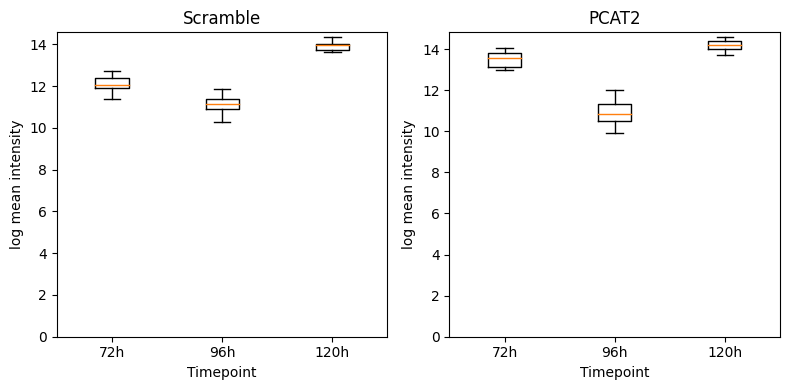

In [10]:



import numpy as np
import matplotlib.pyplot as plt



# Assuming groups72, groups96, groups120, and labels are already defined:
# labels = ['Scramble', 'PCAT1', 'PCAT2', 'CCAT1']
# groups72, groups96, groups120 are lists of arrays in that order

# Create 2x2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Adjusted to have 2 plots instead of 4
axes = axes.flatten()

# Combine the datasets for different timepoints (72h, 96h, and 120h)
datasets = [groups72, groups96, groups120]

# Define timepoints
timepoints = ['72h', '96h', '120h']

# Filter to get the index for Scramble and PCAT2
group_indices = [0, 2]  # Scramble (index 0) and PCAT2 (index 2)

for idx, group_idx in enumerate(group_indices):
    # Get data for the current group (Scramble or PCAT2)
    data = [ds[group_idx] for ds in datasets]
    
    # Apply log2 transformation to the data
    log2_data = [np.log2(d) for d in data]  # Apply log2 to each dataset
    
    ax = axes[idx]
    ax.boxplot(log2_data, labels=timepoints, showfliers=False)
    ax.set_title(labels[group_idx])  # Set title as Scramble or PCAT2
    ax.set_xlabel('Timepoint')
    ax.set_ylabel('log mean intensity')
    ax.set_ylim(bottom=0)  # Set y-axis limit from 0

plt.tight_layout()
plt.show()